# Regression problem

The task is to predict the median price of a house on a given district in California, given past records on sold properties in this US state.

Make sure scikit-optimize is installed:

In [37]:
!pip install scikit-optimize

In [38]:
# setting logging to print only error messages from Sklearnex
import logging
logging.basicConfig()
logging.getLogger("SKLEARNEX").setLevel(logging.ERROR)

import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt

sns.set_theme(palette="Set2")

# execution time
from timeit import default_timer as timer
from datetime import timedelta

# silence warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# increase column width
pd.set_option('display.max_colwidth', 100)

In [39]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load the data

Use the output of the data cleaning step.

In [40]:
trainset = pd.read_csv("trainset-ca-housing.csv")
testset = pd.read_csv("testset-ca-housing.csv")

Create separate arrays for the predictors (`Xtrain` and `Xtest`) and for the target (`ytrain` and `ytest`):

In [41]:
Xtrain = trainset.drop("median_house_value", axis=1)
ytrain = trainset["median_house_value"].copy()
Xtest = testset.drop("median_house_value", axis=1)
ytest = testset["median_house_value"].copy()

In [42]:
Xtrain.shape, Xtest.shape

((15262, 10), (3819, 10))

# Baseline

We'll use a simple baseline: for all test instances, predict the median value seen in the training data:

In [43]:
median_price = ytrain.median()
median_price

174200.0

In [44]:
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import mean_squared_error

# each value in yhat will be the same value, median_price
yhat = np.full((ytrain.shape[0], 1), median_price)
yhat[:10]

array([[174200.],
       [174200.],
       [174200.],
       [174200.],
       [174200.],
       [174200.],
       [174200.],
       [174200.],
       [174200.],
       [174200.]])

In [45]:
baseline_training_mse = root_mean_squared_error(ytrain, yhat)
baseline_training_mse

98893.41775622815

In [46]:
yhat = np.full((ytest.shape[0], 1), median_price)

baseline_test_mse = root_mean_squared_error(ytest, yhat)
baseline_test_mse

99712.47039692692

# Model development

## Evaluating on training set

### Linear regression

In [47]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(Xtrain, ytrain)

LinearRegression()

In [48]:
# make predictions
yhat = lin_reg.predict(Xtrain)

lin_mse = mean_squared_error(ytrain, yhat)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

np.float64(64486.45030851372)

<Axes: >

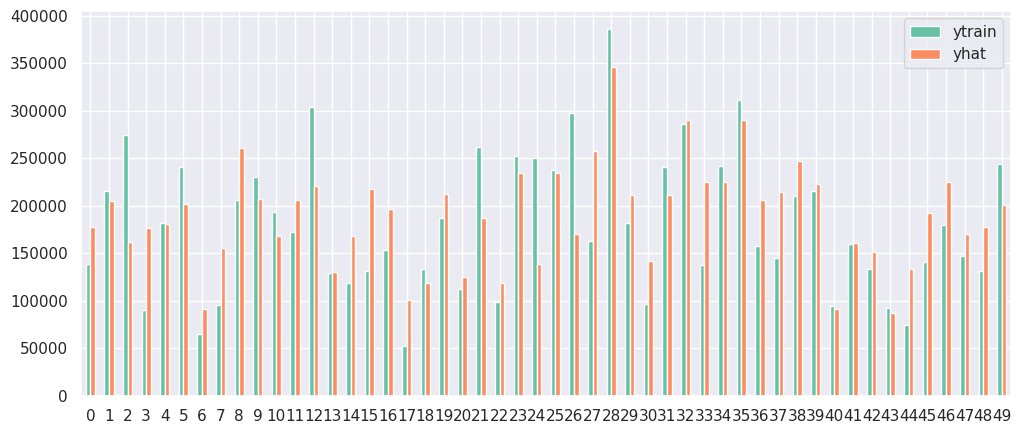

In [49]:
# depict the predictions

# create a temporary dataframe containing two columns
df_tmp = pd.DataFrame({"ytrain": ytrain[:50], "yhat": yhat[:50]})
df_tmp.plot(figsize=(12,5), kind="bar", rot=0)

### Decision Trees

In [50]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=7)
tree_reg.fit(Xtrain, ytrain)
yhat = tree_reg.predict(Xtrain)
tree_rmse = root_mean_squared_error(ytrain, yhat)
tree_rmse

0.0

<Axes: >

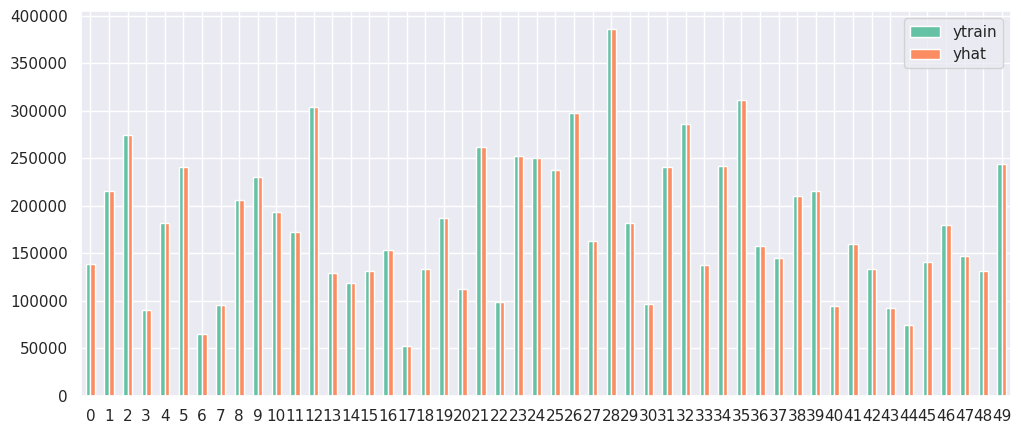

In [51]:
# create a temporary dataframe containing two columns
df_tmp = pd.DataFrame({"ytrain": ytrain[:50], "yhat": yhat[:50]})

# plot the dataframe
df_tmp.plot(figsize=(12,5), kind="bar", rot=0)

In [52]:
# the total number of leaves of the tree
tree_reg.get_n_leaves()

np.int64(15127)

In [53]:
# the depth of the tree
tree_reg.get_depth()

33

## Cross-validation

In [54]:
from sklearn.model_selection import cross_val_score

### Linear regression

In [55]:
lin_reg = LinearRegression()
rmse_scores = -cross_val_score(lin_reg, Xtrain, ytrain,
                               scoring="neg_root_mean_squared_error", cv=10)

In [56]:
rmse_scores

array([62719.91884871, 65497.0888686 , 65951.71962091, 64629.61541717,
       63375.3970824 , 64682.02350943, 66427.00509713, 63798.16956274,
       64288.67591419, 64125.53506529])

In [57]:
rmse_scores.mean()

np.float64(64549.51489865691)

In [58]:
rmse_scores.std()

np.float64(1093.2204088440049)

### Decision Trees

In [59]:
tree_reg = DecisionTreeRegressor(random_state=7)

rmse_scores = -cross_val_score(tree_reg, Xtrain, ytrain,
                               scoring="neg_root_mean_squared_error",
                               cv=10)

In [60]:
rmse_scores.mean()

np.float64(74858.95417057848)

In [61]:
rmse_scores.std()

np.float64(1475.2544895402661)

## Tuning hyperparameters

In [62]:
tree_reg = DecisionTreeRegressor(max_depth=10, max_leaf_nodes=10000,
                                 random_state=7)

rmse_scores = -cross_val_score(tree_reg, Xtrain, ytrain,
                               scoring="neg_root_mean_squared_error",
                               cv=10)

In [63]:
rmse_scores.mean()

np.float64(64104.78857434927)

In [64]:
rmse_scores.std()

np.float64(836.3835027016793)

### Exhaustive grid search

In [65]:
from sklearn.model_selection import GridSearchCV

In [69]:
start = timer()

# specify the hyperparameters and their values
hp_grid = {
    'max_depth': [2, 10, 15, 20, 25],
    'min_samples_leaf': [1, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 10, 20, 30, 40, 50],
    'max_leaf_nodes': [50, None]
}

tree_reg = DecisionTreeRegressor(random_state=7)

# we'll use 10-fold cross-validation
grid_search = GridSearchCV(tree_reg, hp_grid, cv=10,
                           scoring='neg_root_mean_squared_error',
                           return_train_score=True, verbose=2)

grid_search.fit(Xtrain, ytrain)

print("Execution time HH:MM:SS:", timedelta(seconds=timer() - start))

Fitting 10 folds for each of 360 candidates, totalling 3600 fits
[CV] END max_depth=2, max_leaf_nodes=50, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END max_depth=2, max_leaf_nodes=50, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END max_depth=2, max_leaf_nodes=50, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END max_depth=2, max_leaf_nodes=50, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END max_depth=2, max_leaf_nodes=50, min_samples_leaf=1, min_samples_split=2; total time=   0.1s
[CV] END max_depth=2, max_leaf_nodes=50, min_samples_leaf=1, min_samples_split=2; total time=   0.1s
[CV] END max_depth=2, max_leaf_nodes=50, min_samples_leaf=1, min_samples_split=2; total time=   0.1s
[CV] END max_depth=2, max_leaf_nodes=50, min_samples_leaf=1, min_samples_split=2; total time=   0.1s
[CV] END max_depth=2, max_leaf_nodes=50, min_samples_leaf=1, min_samples_split=2; total time=   0.1s
[CV] END max_depth=2, max_

In [70]:
grid_search.best_estimator_

DecisionTreeRegressor(max_depth=15, min_samples_leaf=30, random_state=7)

In [71]:
-grid_search.best_score_

np.float64(60859.95864793115)

In [72]:
cv_results = pd.DataFrame(grid_search.cv_results_)[['params', 'mean_train_score', 'mean_test_score']]
cv_results["mean_train_score"] = -cv_results["mean_train_score"]
cv_results["mean_test_score"] = -cv_results["mean_test_score"]
cv_results["diff, %"] = 100*(cv_results["mean_train_score"]-cv_results["mean_test_score"]
                                                     )/cv_results["mean_train_score"]

cv_results.sort_values('mean_test_score')

,params,mean_train_score,mean_test_score,"diff, %"
198,"{'max_depth': 15, 'max_leaf_nodes': None, 'min_samples_leaf': 30, 'min_samples_split': 2}",53644.666217,60859.958648,-13.450158
199,"{'max_depth': 15, 'max_leaf_nodes': None, 'min_samples_leaf': 30, 'min_samples_split': 10}",53644.666217,60859.958648,-13.450158
202,"{'max_depth': 15, 'max_leaf_nodes': None, 'min_samples_leaf': 30, 'min_samples_split': 40}",53644.666217,60859.958648,-13.450158
203,"{'max_depth': 15, 'max_leaf_nodes': None, 'min_samples_leaf': 30, 'min_samples_split': 50}",53644.666217,60859.958648,-13.450158
200,"{'max_depth': 15, 'max_leaf_nodes': None, 'min_samples_leaf': 30, 'min_samples_split': 20}",53644.666217,60859.958648,-13.450158
...,...,...,...,...
20,"{'max_depth': 2, 'max_leaf_nodes': 50, 'min_samples_leaf': 30, 'min_samples_split': 20}",75879.468806,76077.984255,-0.261619
3,"{'max_depth': 2, 'max_leaf_nodes': 50, 'min_samples_leaf': 1, 'min_samples_split': 30}",75879.468806,76077.984255,-0.261619
2,"{'max_depth': 2, 'max_leaf_nodes': 50, 'min_samples_leaf': 1, 'min_samples_split': 20}",75879.468806,76077.984255,-0.261619
1,"{'max_depth': 2, 'max_leaf_nodes': 50, 'min_samples_leaf': 1, 'min_samples_split': 10}",75879.468806,76077.984255,-0.261619


### Randomized grid search

When the search space of hyperparameters is very large, running exhaustive grid search may take too much time. In such cases, one can try `RandomizedSearchCV` instead. It allows to limit the number of models to build and thus control the amount of computing resources one uses.

The class works very much the same as `GridSearchCV`, but takes extra arguments: `n_iter`, the number of random combinations to try and `random_state`, which can be set to the same constant to ensure that the same random combinations are tried in different runs of the code.

Here, we will try 30 random combinations (`n_iter=30`), instead of an exhaustive search with all possible value combinations.

In [73]:
from sklearn.model_selection import RandomizedSearchCV

In [74]:
start = timer()

# specify the hyperparameters and their values
hp_grid = {
    'max_depth': [2, 10, 15, 20, 25],
    'min_samples_leaf': [1, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 10, 20, 30, 40, 50],
    'max_leaf_nodes': [5000, 10000, None]
}

tree_reg = DecisionTreeRegressor(random_state=7)

# we'll use 10-fold cross-validation
rand_grid_search = RandomizedSearchCV(tree_reg, hp_grid, cv=10, n_iter=30,
                                     scoring='neg_root_mean_squared_error', random_state=7,
                                     return_train_score=True, verbose=2)

rand_grid_search.fit(Xtrain, ytrain)

print("Execution time HH:MM:SS:", timedelta(seconds=timer() - start))

Fitting 10 folds for each of 30 candidates, totalling 300 fits
[CV] END max_depth=25, max_leaf_nodes=10000, min_samples_leaf=20, min_samples_split=40; total time=   0.1s
[CV] END max_depth=25, max_leaf_nodes=10000, min_samples_leaf=20, min_samples_split=40; total time=   0.1s
[CV] END max_depth=25, max_leaf_nodes=10000, min_samples_leaf=20, min_samples_split=40; total time=   0.1s
[CV] END max_depth=25, max_leaf_nodes=10000, min_samples_leaf=20, min_samples_split=40; total time=   0.1s
[CV] END max_depth=25, max_leaf_nodes=10000, min_samples_leaf=20, min_samples_split=40; total time=   0.2s
[CV] END max_depth=25, max_leaf_nodes=10000, min_samples_leaf=20, min_samples_split=40; total time=   0.2s
[CV] END max_depth=25, max_leaf_nodes=10000, min_samples_leaf=20, min_samples_split=40; total time=   0.2s
[CV] END max_depth=25, max_leaf_nodes=10000, min_samples_leaf=20, min_samples_split=40; total time=   0.2s
[CV] END max_depth=25, max_leaf_nodes=10000, min_samples_leaf=20, min_samples_spl

In [75]:
rand_grid_search.best_estimator_

DecisionTreeRegressor(max_depth=15, max_leaf_nodes=10000, min_samples_leaf=30,
                      random_state=7)

Its RMSE score is:

In [76]:
-rand_grid_search.best_score_

np.float64(60859.95864793115)

In [77]:
cv_results = pd.DataFrame(rand_grid_search.cv_results_)[['params', 'mean_train_score', 'mean_test_score']]
cv_results["mean_train_score"] = -cv_results["mean_train_score"]
cv_results["mean_test_score"] = -cv_results["mean_test_score"]
cv_results["diff, %"] = 100*(cv_results["mean_train_score"]-cv_results["mean_test_score"]
                                                     )/cv_results["mean_train_score"]

cv_results.sort_values('mean_test_score')

,params,mean_train_score,mean_test_score,"diff, %"
7,"{'min_samples_split': 2, 'min_samples_leaf': 30, 'max_leaf_nodes': 10000, 'max_depth': 15}",53644.666217,60859.958648,-13.450158
8,"{'min_samples_split': 20, 'min_samples_leaf': 30, 'max_leaf_nodes': None, 'max_depth': 15}",53644.666217,60859.958648,-13.450158
25,"{'min_samples_split': 40, 'min_samples_leaf': 30, 'max_leaf_nodes': 10000, 'max_depth': 25}",53640.278269,60861.733304,-13.462747
21,"{'min_samples_split': 40, 'min_samples_leaf': 30, 'max_leaf_nodes': 10000, 'max_depth': 20}",53640.278269,60861.733304,-13.462747
10,"{'min_samples_split': 50, 'min_samples_leaf': 20, 'max_leaf_nodes': None, 'max_depth': 25}",51628.597029,60870.181156,-17.900126
0,"{'min_samples_split': 40, 'min_samples_leaf': 20, 'max_leaf_nodes': 10000, 'max_depth': 25}",50825.059143,60985.699124,-19.991398
17,"{'min_samples_split': 2, 'min_samples_leaf': 20, 'max_leaf_nodes': None, 'max_depth': 20}",50825.059143,60986.657101,-19.993283
1,"{'min_samples_split': 20, 'min_samples_leaf': 20, 'max_leaf_nodes': None, 'max_depth': 10}",53323.860034,61179.001744,-14.731007
15,"{'min_samples_split': 50, 'min_samples_leaf': 10, 'max_leaf_nodes': 10000, 'max_depth': 10}",52887.589693,61179.686781,-15.678720
13,"{'min_samples_split': 30, 'min_samples_leaf': 30, 'max_leaf_nodes': 10000, 'max_depth': 10}",55032.706487,61220.942527,-11.244651


### Bayesian Optimisation

In [78]:
from skopt import BayesSearchCV

In [79]:
start = timer()

hp_grid = {
         'max_depth': [2, 25],
         'min_samples_leaf': [1, 50],
         'min_samples_split': [2, 50],
         'max_leaf_nodes': [5000, 16000]
     }

opt_grid_search = BayesSearchCV(
     DecisionTreeRegressor(random_state=7),
     hp_grid,
     n_iter=30,
     random_state=7,
     scoring='neg_root_mean_squared_error',
     return_train_score=True,
     cv=10
)

np.int = int
opt_grid_search.fit(Xtrain, ytrain)

print("Execution time HH:MM:SS:", timedelta(seconds=timer() - start))

Execution time HH:MM:SS: 0:01:51.340098


In [80]:
opt_grid_search.best_estimator_

DecisionTreeRegressor(max_depth=23, max_leaf_nodes=5694, min_samples_leaf=16,
                      min_samples_split=50, random_state=7)

In [81]:
-opt_grid_search.best_score_

np.float64(60914.65749817227)

In [82]:
cv_results = pd.DataFrame(opt_grid_search.cv_results_)[['params', 'mean_train_score', 'mean_test_score']]
cv_results["mean_train_score"] = -cv_results["mean_train_score"]
cv_results["mean_test_score"] = -cv_results["mean_test_score"]
cv_results["diff, %"] = 100*(cv_results["mean_train_score"]-cv_results["mean_test_score"]
                                                     )/cv_results["mean_train_score"]

cv_results.sort_values('mean_test_score')

,params,mean_train_score,mean_test_score,"diff, %"
24,"{'max_depth': 22, 'max_leaf_nodes': 6042, 'min_samples_leaf': 16, 'min_samples_split': 50}",50905.800053,60914.657498,-19.661527
25,"{'max_depth': 22, 'max_leaf_nodes': 6055, 'min_samples_leaf': 16, 'min_samples_split': 50}",50905.800053,60914.657498,-19.661527
23,"{'max_depth': 22, 'max_leaf_nodes': 6043, 'min_samples_leaf': 16, 'min_samples_split': 50}",50905.800053,60914.657498,-19.661527
22,"{'max_depth': 22, 'max_leaf_nodes': 6007, 'min_samples_leaf': 16, 'min_samples_split': 50}",50905.800053,60914.657498,-19.661527
27,"{'max_depth': 22, 'max_leaf_nodes': 6138, 'min_samples_leaf': 16, 'min_samples_split': 50}",50905.800053,60914.657498,-19.661527
26,"{'max_depth': 22, 'max_leaf_nodes': 6064, 'min_samples_leaf': 16, 'min_samples_split': 50}",50905.800053,60914.657498,-19.661527
29,"{'max_depth': 22, 'max_leaf_nodes': 6088, 'min_samples_leaf': 16, 'min_samples_split': 50}",50905.800053,60914.657498,-19.661527
28,"{'max_depth': 22, 'max_leaf_nodes': 6060, 'min_samples_leaf': 16, 'min_samples_split': 50}",50905.800053,60914.657498,-19.661527
20,"{'max_depth': 22, 'max_leaf_nodes': 5941, 'min_samples_leaf': 16, 'min_samples_split': 50}",50905.800053,60914.657498,-19.661527
21,"{'max_depth': 22, 'max_leaf_nodes': 5985, 'min_samples_leaf': 16, 'min_samples_split': 50}",50905.800053,60914.657498,-19.661527


# Evaluate on the test set

In [83]:
best_model = grid_search.best_estimator_

yhat = best_model.predict(Xtest)

final_rmse = root_mean_squared_error(ytest, yhat)
final_rmse

60011.87665270731

<Axes: >

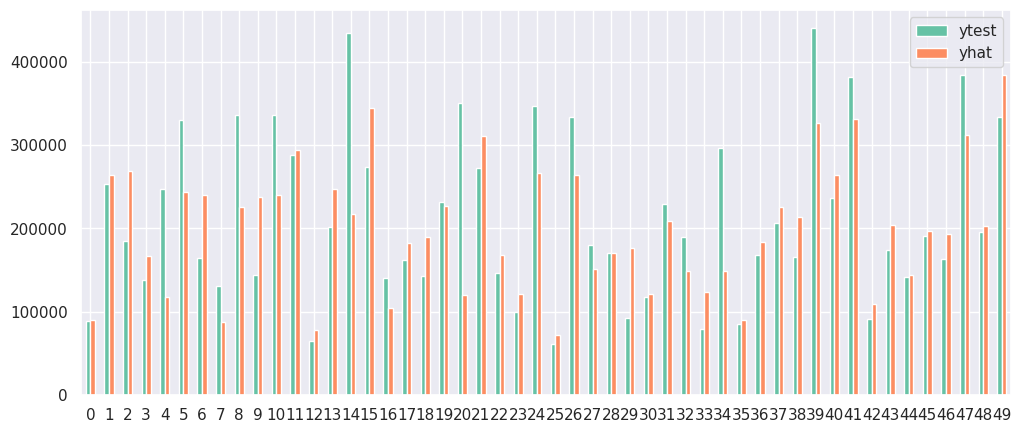

In [84]:
# create a temporary dataframe containing two columns
df_tmp = pd.DataFrame({"ytest": ytest[:50], "yhat": yhat[:50]})

# plot the dataframe
df_tmp.plot(figsize=(12,5), kind="bar", rot=0)

## Analyze important predictors

### Gini importances

In [85]:
# put them into a separate variable for convenience
feature_importances = grid_search.best_estimator_.feature_importances_

for k, v in sorted(zip(feature_importances, Xtrain.columns), reverse=True):
    print(f"{v}: {k:.3f}")

median_income: 0.624
longitude: 0.137
rooms_per_household: 0.084
housing_median_age: 0.065
ocean_proximity_NEAR OCEAN: 0.030
total_bedrooms: 0.025
population: 0.018
total_rooms: 0.007
ocean_proximity_NEAR BAY: 0.006
households: 0.005


### Permutation importances

In [86]:
from sklearn.inspection import permutation_importance

result = permutation_importance(grid_search.best_estimator_, Xtest, ytest,
                                n_repeats=10, random_state=7,
                                scoring='neg_root_mean_squared_error')

In [87]:
# raw permutation importance scores
sorted_importances_idx = result.importances_mean.argsort()
raw_importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=Xtrain.columns[sorted_importances_idx],
)
raw_importances

,ocean_proximity_NEAR BAY,total_rooms,households,population,total_bedrooms,ocean_proximity_NEAR OCEAN,housing_median_age,rooms_per_household,longitude,median_income
0,420.378987,443.634659,811.467557,2504.653756,4532.573937,6198.250960,6526.052566,7173.812886,15613.788156,57206.465685
1,478.480819,557.251700,627.163507,2531.950379,5028.155166,6168.299083,7551.802003,6925.388854,15029.163798,58361.997505
2,480.933656,565.791377,769.270946,2020.168329,5068.788328,6798.300424,7703.862778,7437.452786,14527.192815,57417.700622
3,541.920570,868.669287,612.281546,2198.619516,5602.176706,6088.479356,6605.064923,7612.666558,15010.813351,58862.622904
4,763.489751,435.065710,721.662248,2196.892568,4928.408050,6427.149471,7705.948089,7735.719335,15981.231442,56862.240216
5,478.206674,444.209927,810.267109,2027.303047,4882.718302,6188.897322,6200.660905,6893.315324,14656.030082,58132.693194
6,399.119014,458.316295,718.166109,2360.968233,5785.347052,6722.132119,6729.297786,7268.746794,14479.040231,57626.030190
7,546.567633,416.898092,466.561770,2125.856298,4861.517171,6469.294174,6868.502185,6960.888583,15058.954916,58222.043604
8,395.393767,748.083616,528.658633,2049.907544,6107.408294,6020.588758,6718.199064,7263.240204,15657.024681,58872.838494
9,510.746119,491.325327,910.630201,2431.080317,4954.831641,6392.644424,6738.718451,7422.103944,15514.084297,58645.878740


In [88]:
result.importances_mean

array([15152.73237676,  6934.81087491,   542.92459901,  5175.19246465,
        2244.73999878,   697.61296262, 58021.05111522,  7269.33352682,
         501.52369911,  6347.40360898])

In [89]:
Xtest.columns

Index(['longitude', 'housing_median_age', 'total_rooms', 'total_bedrooms',
       'population', 'households', 'median_income', 'rooms_per_household',
       'ocean_proximity_NEAR BAY', 'ocean_proximity_NEAR OCEAN'],
      dtype='object')

In [90]:
pd.Series(result.importances_mean, index=Xtest.columns).sort_values(ascending=False)

,0
median_income,58021.051115
longitude,15152.732377
rooms_per_household,7269.333527
housing_median_age,6934.810875
ocean_proximity_NEAR OCEAN,6347.403609
total_bedrooms,5175.192465
population,2244.739999
households,697.612963
total_rooms,542.924599
ocean_proximity_NEAR BAY,501.523699


# Citing this notebook

If you use this notebook in your work, please cite it as follows:
    
Pekar, V. (2024). Machine Learning for Business Analytics. Lecture examples and exercises. (Version 1.0.0). URL: https://github.com/vpekar/bd4dm